### Imports

In [1]:
!pip install scikit-learn-extra
!pip install folium
!pip install geopy
!pip install nltk
!pip install gensim
!pip install -U scikit-learn
!pip install shapely
!pip install seaborn
!pip install plotly
!pip install statsmodels
!pip install tabulate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 38.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 2.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 2.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 kB 14.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 41.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.

In [2]:
import pandas as pd
import numpy as np
import folium
import geopy
import matplotlib.pyplot as plt
import time
import seaborn as sns
import plotly.express as px

from sklearn_extra.cluster import KMedoids
from folium.plugins import HeatMap
from shapely.geometry import Point, Polygon
from geopy.geocoders import Nominatim
from collections import defaultdict

from tabulate import tabulate
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize  

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,silhouette_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Getting the data

In [36]:
file_path = 'Motor_Vehicle_Collisions_-_Crashes.csv'
df = pd.read_csv(file_path)

## Data Preparation

In [31]:
# merge off street name inside on street and drop location
replace_nan_with_off_street = lambda row: row['OFF STREET NAME'] if pd.isna(row['ON STREET NAME']) else row['ON STREET NAME']
df['ON STREET NAME'] = df.apply(replace_nan_with_off_street, axis=1)
df = df.drop(columns = ['LOCATION','OFF STREET NAME'])

df

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,1.0,0.0,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,06/29/2022,6:55,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,0.0,0.0,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
3,09/11/2021,9:35,BROOKLYN,11208.0,40.667202,-73.866500,1211 LORING AVENUE,NaN,0.0,0.0,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
4,12/14/2021,8:13,BROOKLYN,11233.0,40.683304,-73.917274,SARATOGA AVENUE,DECATUR STREET,0.0,0.0,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046247,11/26/2023,7:30,QUEENS,11377.0,40.742740,-73.892830,WOODSIDE AVENUE,72 STREET,0.0,0.0,...,Unspecified,NaN,NaN,NaN,4682515,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN
2046248,11/21/2023,8:50,QUEENS,11362.0,40.766273,-73.740074,NORTHERN BOULEVARD,247 STREET,1.0,0.0,...,Unspecified,NaN,NaN,NaN,4682926,Sedan,Sedan,NaN,NaN,NaN
2046249,11/19/2023,18:26,STATEN ISLAND,10306.0,40.558020,-74.137400,JUSTIN AVENUE,AMBOY ROAD,0.0,0.0,...,Unspecified,NaN,NaN,NaN,4682944,Sedan,NaN,NaN,NaN,NaN
2046250,11/26/2023,12:30,QUEENS,11691.0,40.606514,-73.754684,13-29 BEACH CHANNEL DRIVE,NaN,0.0,0.0,...,Unspecified,NaN,NaN,NaN,4682969,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


In [32]:
def create_dict_steet_coord(df):
    dict_strade_coord = {}
    for _, row in df.iterrows():
        nome_strada = row['ON STREET NAME']
        latitudine = row['LATITUDE']
        longitudine = row['LONGITUDE']
        borough = row['BOROUGH']
        zip_code = row['ZIP CODE']

        # Save in the dictionary
        if not pd.isna(nome_strada) and not pd.isna(latitudine) and not pd.isna(longitudine) and not pd.isna(borough) and not pd.isna(zip_code):
            dict_strade_coord[nome_strada] = {'LATITUDE': latitudine, 'LONGITUDE': longitudine, 'BOROUGH' : borough, 'ZIP CODE' : zip_code}

    return dict_strade_coord

def update_coord(df, dict_strade_coord):
    for index, row in df.iterrows():
        nome_strada = row['ON STREET NAME']
        latitudine = row['LATITUDE']
        longitudine = row['LONGITUDE']
        borough = row['BOROUGH']
        zip_code = row['ZIP CODE']

        if pd.isna(latitudine) and pd.isna(longitudine):
            if nome_strada in dict_strade_coord:
                df.at[index, 'LATITUDE'] = dict_strade_coord[nome_strada]['LATITUDE']
                df.at[index, 'LONGITUDE'] = dict_strade_coord[nome_strada]['LONGITUDE']

        if pd.isna(borough):
            if nome_strada in dict_strade_coord:
                df.at[index, 'BOROUGH'] = dict_strade_coord[nome_strada]['BOROUGH']

        if pd.isna(zip_code):
            if nome_strada in dict_strade_coord:
                df.at[index, 'ZIP CODE'] = dict_strade_coord[nome_strada]['ZIP CODE']

df2= df.copy()
start_time = time.time()
street_map_coord = create_dict_steet_coord(df2)
print("--- Execution time to create the map: %s seconds ---" % (time.time() - start_time))

# Measures the execution time of the DataFrame update
start_time = time.time()
update_coord(df2, street_map_coord)
print("--- Execution time to update the dataframe: %s seconds ---" % (time.time() - start_time))



--- Execution time to create the map: 91.79538154602051 seconds ---
--- Execution time to update the dataframe: 110.31109666824341 seconds ---


In [33]:
print("Numbers of rows before the recostruction with all information about latitude, longitude and zip code")
df_location = df.dropna(subset=['LATITUDE', 'LONGITUDE','BOROUGH', 'ZIP CODE']) 
print(len(df_location))

print("Numbers of rows after the recostruction with all information about latitude, longitude and zip code")
df2_location = df2.dropna(subset=['LATITUDE', 'LONGITUDE','BOROUGH', 'ZIP CODE']) 
print(len(df2_location)) 

Numbers of rows before the recostruction with all information about latitude, longitude and zip code
1372875
Numbers of rows after the recostruction with all information about latitude, longitude and zip code
1870317


In [34]:
# Drop row where zip code is empty
df2_location = df2_location[df2_location['ZIP CODE'].str.strip() != '']
print(f"Numbers of rows after removing row with malformatted zipcode {len(df2_location)}")

Numbers of rows after removing row with malformatted zipcode 1870275


In [35]:
print("Numbers of rows in the dataset with all information about location and street name")
df2_location_street = df2_location.dropna(subset=['ON STREET NAME', 'CROSS STREET NAME'], how='all')
print(len(df2_location_street))

print("We can try to reconstruct street from location with API:")
print(len(df2_location) - len(df2_location_street))

Numbers of rows in the dataset with all information about location and street name
1869690
We can try to reconstruct street from location with API:
585


In [36]:
# Create a Nominatim geolocator object
geolocator = Nominatim(user_agent="my_geocoder")

# Function to obtain street name given latitude and longitude
def get_street_name(lat, lon):
    if pd.notna(lat) and pd.notna(lon):
        location = geolocator.reverse((lat, lon), language='en')
        if location and 'address' in location.raw:
            return location.raw['address'].get('road', None)
    return None

# Function to apply logic to the row and print the counter
def fill_on_street_name(row):
    if pd.isna(row['ON STREET NAME']) and pd.isna(row['CROSS STREET NAME']):
        return get_street_name(row['LATITUDE'], row['LONGITUDE'])
    else:
        return row['ON STREET NAME']

# Applies the function to each row in the DataFrame
df2_location['ON STREET NAME'] = df2_location.apply(fill_on_street_name, axis=1)


In [37]:
print("Numbers of rows after the API:")
print(len(df2_location))

print("Numbers of rows without complete data of location, zip, borough and street name after preprocessing:")
df2_location_street = df2_location.dropna(subset=['LATITUDE', 'LONGITUDE','BOROUGH', 'ZIP CODE','ON STREET NAME']) 
print(len(df2_location_street))

Numbers of rows after the API:
1870275
Numbers of rows without complete data of location, zip, borough and street name after preprocessing:
1870273


In [ ]:
# Some sums were in Nan, we recalculate them using the other columns.
columns_to_sum = ['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED']
destination_column = 'NUMBER OF PERSONS INJURED'

# Replace the values in the target column with the sum of the other columns only when it is nan
df2_location_street[destination_column] = np.where(df2_location_street[destination_column].isnull(), df2_location_street[columns_to_sum].sum(axis=1), df2_location_street[destination_column])

# Same for killed
columns_to_sum = ['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']
destination_column = 'NUMBER OF PERSONS KILLED'

df2_location_street[destination_column] = np.where(df2_location_street[destination_column].isnull(), df2_location_street[columns_to_sum].sum(axis=1), df2_location_street[destination_column])

In [39]:
# OUTLIER REMOVAL
# new york polygon
nyc_polygon_vertices = [
    (-74.2591, 40.4774),  # south west (Staten Island)
    (-73.7002, 40.4774),  # south east (Brooklyn)
    (-73.7002, 40.9176),  # north east (Queens)
    (-74.2591, 40.9176),  # north west (Manhattan e Bronx)
]

ny_polygon = Polygon(nyc_polygon_vertices)

def is_inside_new_york(lat, lon):
    point = Point(lon, lat)
    return ny_polygon.contains(point)

df_inside_ny = df2_location_street[df2_location_street.apply(lambda row: is_inside_new_york(row['LATITUDE'], row['LONGITUDE']), axis=1)]

print(f"Number of removed outliers: {len(df2_location_street)-len(df_inside_ny)}")


Number of removed outliers: 4398


In [40]:
df_inside_ny.to_csv('processed_data.csv', index=False)

## Data Visualization

In [8]:
df = pd.read_csv('processed_data.csv')

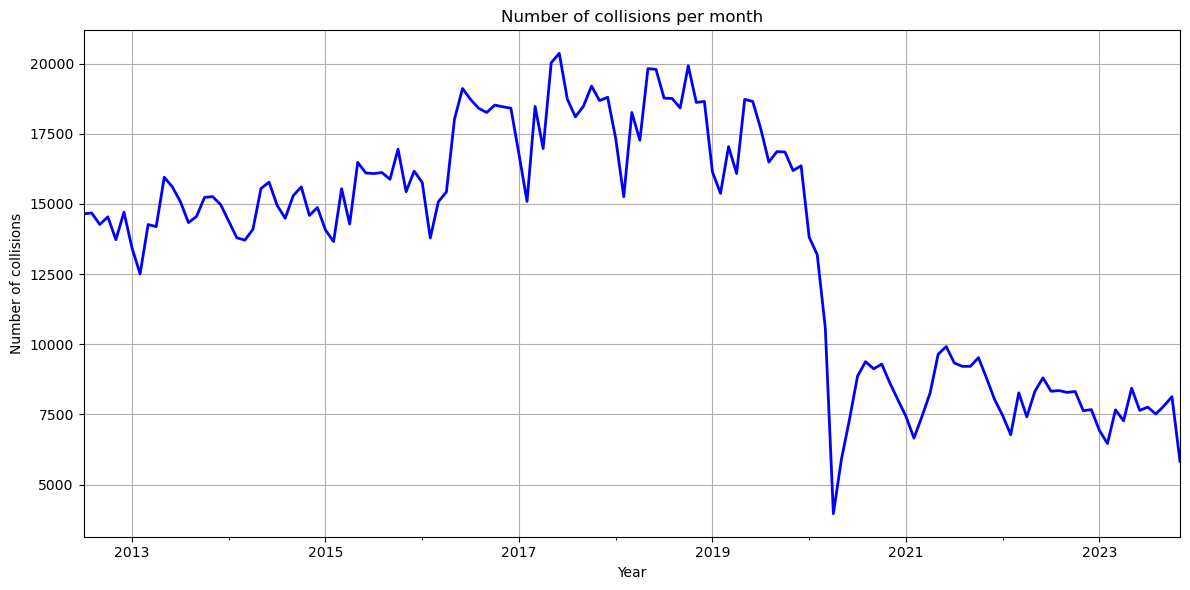

In [9]:
def plot_monthly_collision_trend(database):
    # Convert "CRASH DATE" to datetime
    database['CRASH DATE'] = pd.to_datetime(database['CRASH DATE'])

    # Extract the month from the "CRASH DATE" column.
    database['Month'] = database['CRASH DATE'].dt.to_period('M')

    # Group by month and count the number of collisions in each month
    monthly_data = database.groupby('Month').size()

    plt.figure(figsize=(12, 6))
    monthly_data.plot(linewidth=2, color='b')

    plt.title('Number of collisions per month')
    plt.xlabel('Year')
    plt.ylabel('Number of collisions')
    plt.grid(True)

    # Show the plot
    plt.tight_layout() 
    plt.show()

plot_monthly_collision_trend(df)


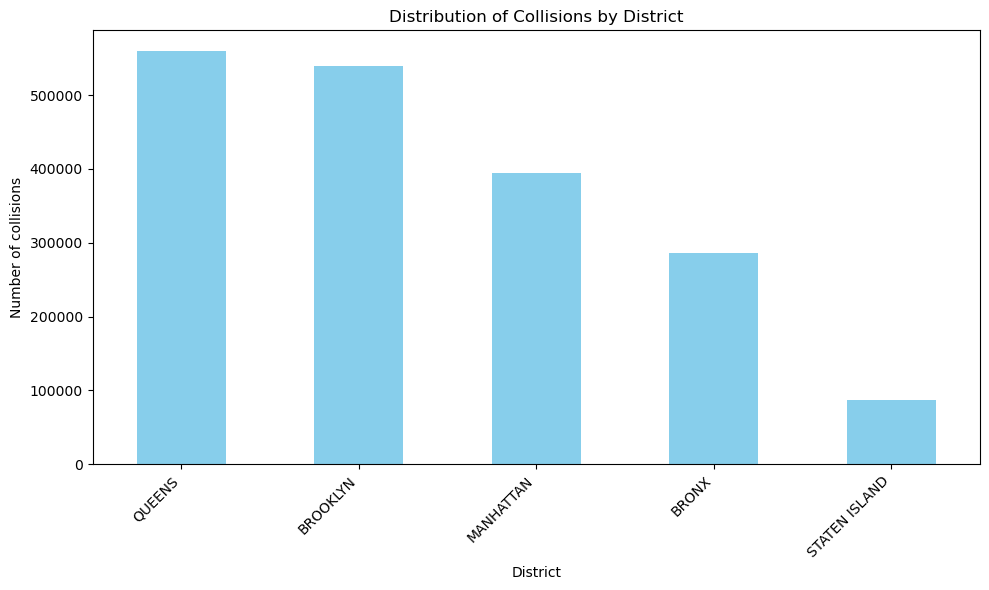

In [25]:
# Group by district and count the total number of collisions in each district.
def collisions_by_district(dataframe):
    borough_collisions = dataframe['BOROUGH'].value_counts()

    plt.figure(figsize=(10, 6))
    borough_collisions.plot(kind='bar', color='skyblue')

    plt.title('Distribution of Collisions by District')
    plt.xlabel('District')
    plt.ylabel('Number of collisions')
    plt.xticks(rotation=45, ha='right') 

    # Plot the graph
    plt.tight_layout()
    plt.show()

collisions_by_district(df)

In [10]:
# Create a map centered on New York
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Add a heat map using collision coordinates
heat_data = [[row['LATITUDE'], row['LONGITUDE']] for index, row in df.iterrows()]
HeatMap(heat_data).add_to(map_nyc)

# Save the map
map_nyc.save('collision_map.html')

In [27]:
df_killed_injured = df.copy()

# Extract 'Year' column from CRASH DATE
df_killed_injured['Year'] = df_killed_injured['CRASH DATE'].dt.year 

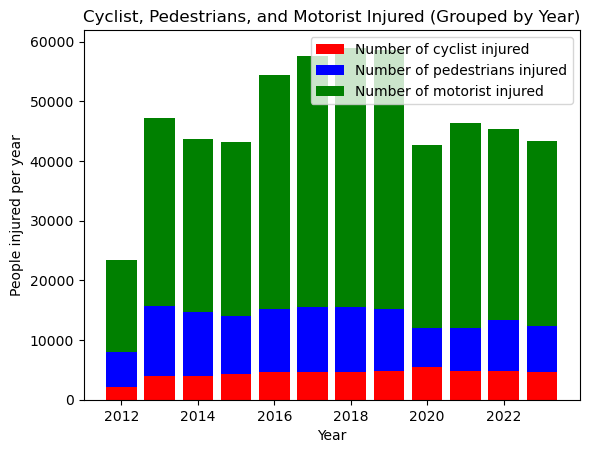

In [28]:
# Group by year and calculate the sum 
df_grouped = df_killed_injured.groupby('Year').agg({'NUMBER OF CYCLIST INJURED': 'sum', 'NUMBER OF MOTORIST INJURED': 'sum','NUMBER OF PEDESTRIANS INJURED' : 'sum'}).reset_index()

# Plot
fig, ax = plt.subplots()

ax.bar(df_grouped['Year'], df_grouped['NUMBER OF CYCLIST INJURED'], label='Number of cyclist injured', color='red')
ax.bar(df_grouped['Year'], df_grouped['NUMBER OF PEDESTRIANS INJURED'], bottom=df_grouped['NUMBER OF CYCLIST INJURED'], label='Number of pedestrians injured', color='blue')
ax.bar(df_grouped['Year'], df_grouped['NUMBER OF MOTORIST INJURED'], bottom=df_grouped['NUMBER OF CYCLIST INJURED']+df_grouped['NUMBER OF PEDESTRIANS INJURED'], label='Number of motorist injured', color='green')

ax.set_ylabel('People injured per year')
ax.set_xlabel('Year')
ax.set_title('Cyclist, Pedestrians, and Motorist Injured (Grouped by Year)')
ax.legend()

plt.show()

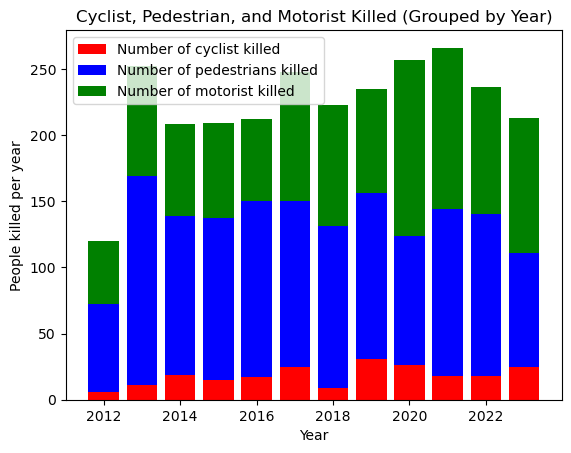

In [29]:
# Group by year and calculate the sum 
df_grouped = df_killed_injured.groupby('Year').agg({'NUMBER OF CYCLIST KILLED': 'sum', 'NUMBER OF MOTORIST KILLED': 'sum','NUMBER OF PEDESTRIANS KILLED' : 'sum'}).reset_index()

# Plot
fig, ax = plt.subplots()

ax.bar(df_grouped['Year'], df_grouped['NUMBER OF CYCLIST KILLED'], label='Number of cyclist killed', color='red')
ax.bar(df_grouped['Year'], df_grouped['NUMBER OF PEDESTRIANS KILLED'], bottom=df_grouped['NUMBER OF CYCLIST KILLED'], label='Number of pedestrians killed', color='blue')
ax.bar(df_grouped['Year'], df_grouped['NUMBER OF MOTORIST KILLED'], bottom=df_grouped['NUMBER OF CYCLIST KILLED']+df_grouped['NUMBER OF PEDESTRIANS KILLED'], label='Number of motorist killed', color='green')

ax.set_ylabel('People killed per year')
ax.set_xlabel('Year')
ax.set_title('Cyclist, Pedestrian, and Motorist Killed (Grouped by Year)')
ax.legend()

plt.show()

In [30]:
# Calculates the occurrences of each value in the column
value_counts = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()

# Calculate the percentage of each value to the total
percentages = value_counts / value_counts.sum() * 100

result_df = pd.DataFrame({
    'Value': value_counts.index,
    'Occurrences': value_counts.values,
    'Percentage': percentages.values
})

# Sort the DataFrame by the number of occurrences
result_df = result_df.sort_values(by='Occurrences', ascending=False)
print(result_df)

                             Value  Occurrences  Percentage
0                      Unspecified       639680   34.399831
1   Driver Inattention/Distraction       376623   20.253514
2    Failure to Yield Right-of-Way       116131    6.245133
3            Following Too Closely        97673    5.252524
4                 Backing Unsafely        71043    3.820453
..                             ...          ...         ...
56           Windshield Inadequate           67    0.003603
57          Cell Phone (hand-held)           62    0.003334
58                         Texting           47    0.002528
59      Listening/Using Headphones           21    0.001129
60                               1            8    0.000430

[61 rows x 3 columns]


##  Data Processing and Knowledge Extraction

### Dimentionality Reduction through Word2Vec

In [31]:
# Shows contributing factors present in our dataset 
df_unique = df['CONTRIBUTING FACTOR VEHICLE 1'].unique()
print(df_unique)

['Aggressive Driving/Road Rage' 'Unspecified' nan 'Passing Too Closely'
 'Driver Inexperience' 'Passing or Lane Usage Improper'
 'Turning Improperly' 'Unsafe Speed' 'Reaction to Uninvolved Vehicle'
 'Steering Failure' 'Traffic Control Disregarded' 'Following Too Closely'
 'Other Vehicular' 'Driver Inattention/Distraction' 'Pavement Slippery'
 'Oversized Vehicle' 'Alcohol Involvement' 'View Obstructed/Limited'
 'Failure to Yield Right-of-Way' 'Unsafe Lane Changing' 'Illnes'
 'Lost Consciousness' 'Brakes Defective' 'Backing Unsafely'
 'Passenger Distraction' 'Fell Asleep'
 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion'
 'Obstruction/Debris' 'Tinted Windows' 'Animals Action' 'Drugs (illegal)'
 'Pavement Defective' 'Outside Car Distraction'
 'Driverless/Runaway Vehicle' 'Tire Failure/Inadequate' 'Fatigued/Drowsy'
 'Headlights Defective' 'Accelerator Defective' 'Failure to Keep Right'
 'Physical Disability' 'Glare' 'Other Lighting Defects'
 'Eating or Drinking' 'Cell Phone (hands-f

In [ ]:
# Convert contributing factor to lower case
df['CONTRIBUTING FACTOR VEHICLE 1'] = df['CONTRIBUTING FACTOR VEHICLE 1'].str.lower()
# Remove CONTRIBUTING FACTOR with no sense (we will not take care of these values)
df = df[df['CONTRIBUTING FACTOR VEHICLE 1'] != '1'] 
df = df[df['CONTRIBUTING FACTOR VEHICLE 1'] != '80'] 
df = df.dropna(subset =['CONTRIBUTING FACTOR VEHICLE 1'], how='any')

# Extract singular values for contributing
df_similarity = df.drop_duplicates(subset='CONTRIBUTING FACTOR VEHICLE 1')
df_similarity.loc[:, 'CONTRIBUTING FACTOR VEHICLE 1'] = df_similarity['CONTRIBUTING FACTOR VEHICLE 1'].replace('vehicle vandalism', 'vehicle damaged')
# Drop unspecified
df_similarity = df_similarity[df_similarity['CONTRIBUTING FACTOR VEHICLE 1'] != 'unspecified'] 

# Now we are ready to try to find similarities   
# Tokenization and conversion to lower case
sentences = [word_tokenize(sentence) for sentence in df_similarity['CONTRIBUTING FACTOR VEHICLE 1']]

# Trains Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=1, min_count=1, workers=4, sg=0)
threshold_similarity = 0.55

similar_values_dict = defaultdict(list)

# Compare the motivations
for i, motivation1 in enumerate(sentences):
    for j, motivation2 in enumerate(sentences):
        if i < j:  # Avoid duplicate couple like (a,b) and (b,a)
            similarity = cosine_similarity(model.wv[motivation1].mean(axis=0).reshape(1, -1),
                                          model.wv[motivation2].mean(axis=0).reshape(1, -1))[0][0]
            if similarity > threshold_similarity:
                # Merge token to original motivation
                motivation1_str = ' '.join(motivation1)
                motivation2_str = ' '.join(motivation2)

                if motivation2_str not in similar_values_dict:
                    similar_values_dict[motivation1_str].append(motivation2_str)

print("Similar motivations to join:")
for key, values in similar_values_dict.items():
    print(f"{key}: {values}")

Similar motivations to join:
passing too closely: ['following too closely']
reaction to uninvolved vehicle: ['reaction to other uninvolved vehicle']
pavement defective: ['tow hitch defective']
driverless/runaway vehicle: ['vehicle damaged']
cell phone ( hands-free ): ['cell phone ( hand-held )']


In [ ]:
# We create manual better association
manual_dictionary = {
    'passing too closely': ['following too closely'], 
    'reaction to uninvolved vehicle' : ['reaction to other uninvolved vehicle'],
    'pavement defective': ['pavement slippery', 'obstruction/debris'],
    'failure to yield right-of-way': ['failure to keep right'],
    'cell phone' : ['cell phone (hands-free)','cell phone (hand-held)','other electronic device','listening/using headphones','texting'],
    'car problems' : ['brakes defective','steering failure','tire failure/inadequate','accelerator defective','headlights defective', 'vehicle vandalism', 'tow hitch defective','tinted windows'],
    'driver inattention' : ['driver inattention/distraction','driver inexperience','backing unsafely'],
    'driver distraction':['passenger distraction', 'using on board navigation device','outside car distraction','eating or drinking','glare'],
    'passing or lane usage improper':['unsafe lane changing'],
    'driver alterate conditions':['fell asleep','lost consciousness','illnes','drugs (illegal)','fatigued/drowsy','alcohol involvement','shoulders defective/improper','prescription medication']
}

### Result of Dimentionality Reduction

In [ ]:
df_reduction = df.copy()
df_man_reduction = df.copy()

def replace_values(value, dictionary):
    for key, values in dictionary.items():
        if value in values:
            return key
    return value

unique_elements_count = df['CONTRIBUTING FACTOR VEHICLE 1'].nunique()
print(f"Unique element in column 'CONTRIBUTING FACTOR VEHICLE 1' before reduction: {unique_elements_count}")

df_reduction['CONTRIBUTING FACTOR VEHICLE 1'] = df_reduction['CONTRIBUTING FACTOR VEHICLE 1'].apply(lambda x: replace_values(x, similar_values_dict))
unique_elements_count = df_reduction['CONTRIBUTING FACTOR VEHICLE 1'].nunique()
print(f"Unique element in column 'CONTRIBUTING FACTOR VEHICLE 1' after reduction: {unique_elements_count}")

df_man_reduction['CONTRIBUTING FACTOR VEHICLE 1'] = df_man_reduction['CONTRIBUTING FACTOR VEHICLE 1'].apply(lambda x: replace_values(x, manual_dictionary))
unique_elements_count = df_man_reduction['CONTRIBUTING FACTOR VEHICLE 1'].nunique()
print(f"Unique element in column 'CONTRIBUTING FACTOR VEHICLE 1' after manual reduction: {unique_elements_count}")

Unique element in column 'CONTRIBUTING FACTOR VEHICLE 1' before reduction: 57
Unique element in column 'CONTRIBUTING FACTOR VEHICLE 1' after reduction: 54
Unique element in column 'CONTRIBUTING FACTOR VEHICLE 1' after manual reduction: 27


In [ ]:
print(df_man_reduction['CONTRIBUTING FACTOR VEHICLE 1'].unique())

['aggressive driving/road rage' 'unspecified' 'passing too closely'
 'driver inattention' 'passing or lane usage improper'
 'turning improperly' 'unsafe speed' 'reaction to uninvolved vehicle'
 'car problems' 'traffic control disregarded' 'other vehicular'
 'pavement defective' 'oversized vehicle' 'driver alterate conditions'
 'view obstructed/limited' 'failure to yield right-of-way'
 'driver distraction'
 'pedestrian/bicyclist/other pedestrian error/confusion' 'animals action'
 'driverless/runaway vehicle' 'physical disability'
 'other lighting defects' 'cell phone' 'lane marking improper/inadequate'
 'traffic control device improper/non-working' 'windshield inadequate'
 'illness']


## Supervised Classification for Missing Motivation

### Apply Random Forest to different DataFrame

In [18]:
# !! Computationally Expensive
def RandomForest(df): 

    # Columns to be use for prediction
    features = ['BOROUGH', 'ZIP CODE', 'ON STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']
    df = df.dropna(subset = (features + ['CONTRIBUTING FACTOR VEHICLE 1']), how='any')

    # Select only useful columns
    df = df.loc[:, (features + ['CONTRIBUTING FACTOR VEHICLE 1'])]

    # Encode string variables
    le = LabelEncoder()
    df['BOROUGH'] = le.fit_transform(df['BOROUGH'])
    df['ON STREET NAME'] = le.fit_transform(df['ON STREET NAME'])
    
    # Zip code need to be convert as integer
    df['ZIP CODE'] = df['ZIP CODE'].astype(float).astype('Int64')

    # We will not include Unspecified in train and test data
    df_without_unspecified = df[df['CONTRIBUTING FACTOR VEHICLE 1'] != 'unspecified']  
    
    train_df, test_df = train_test_split(df_without_unspecified, test_size=0.2, random_state=42)

    # Create the model
    model = RandomForestClassifier(random_state=42)
   
    # Train the model
    model.fit(train_df[features], train_df['CONTRIBUTING FACTOR VEHICLE 1'])
    print(" Model done")
    
    # Make prediction
    predictions = model.predict(test_df[features])

    # Calcoulate accuracy
    accuracy = accuracy_score(test_df['CONTRIBUTING FACTOR VEHICLE 1'], predictions)
    print(f' Accuracy: {accuracy}') 

print("With original dataframe:")
RandomForest(df.copy())
print("With automatic reduced dataframe:")
RandomForest(df_reduction.copy())
print("With manual reduced dataframe:")
RandomForest(df_man_reduction.copy())

With original dataframe:
 Model done
 Accuracy: 0.28054124292395793
With automatic reduced dataframe:
 Model done
 Accuracy: 0.28375492402349595
With manual reduced dataframe:
 Model done
 Accuracy: 0.3573908516664822


### Random Forest Tuning
#### n_estimators and max_depth

In [36]:
def RandomForest(df, n_estimators=100, max_depth=None): 
    # Columns to be used for prediction
    features = ['BOROUGH_enc', 'ZIP CODE_enc', 'ON STREET NAME_enc', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']

    # Encode variables
    le = LabelEncoder()
    df['BOROUGH_enc'] = le.fit_transform(df['BOROUGH'])
    df['ON STREET NAME_enc'] = le.fit_transform(df['ON STREET NAME'])
    # Zip code need to be convert as integer
    df['ZIP CODE_enc'] = df['ZIP CODE'].astype(float).astype('Int64')

    df = df.dropna(subset=(features + ['CONTRIBUTING FACTOR VEHICLE 1']), how='any')

    # Dataframe to construct the model
    df_enc = df.loc[:, (features + ['CONTRIBUTING FACTOR VEHICLE 1'])]
    df_enc_without_unspecified = df_enc[df_enc['CONTRIBUTING FACTOR VEHICLE 1'] != 'unspecified']  
    
    train_df, test_df = train_test_split(df_enc_without_unspecified, test_size=0.2, random_state=42)

    # Create the model with specified parameters
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
   
    # Train the model
    model.fit(train_df[features], train_df['CONTRIBUTING FACTOR VEHICLE 1'])
    print(f"Model done - n_estimators: {n_estimators}, max_depth: {max_depth}") 

    # Make prediction
    predictions = model.predict(test_df[features])
    
    # Calculate accuracy
    accuracy = accuracy_score(test_df['CONTRIBUTING FACTOR VEHICLE 1'], predictions)
    print(f'Accuracy: {accuracy}')
    
    # Use the model to make predictions about original data with "unspecified" values 
    unspecified_data = df[df['CONTRIBUTING FACTOR VEHICLE 1'] == 'unspecified']
    unspecified_predictions = model.predict(unspecified_data[features])

    # Save the predicted values in the original dataset
    df.loc[df['CONTRIBUTING FACTOR VEHICLE 1'] == 'unspecified', 'CONTRIBUTING FACTOR VEHICLE 1'] = unspecified_predictions

    # Drop encoded columuns
    return df.drop(columns=['BOROUGH_enc', 'ZIP CODE_enc', 'ON STREET NAME_enc'])


# List of parameter sets to be tested
param_sets = [
    {'n_estimators': 50, 'max_depth': 10},
    {'n_estimators': 100, 'max_depth': 20},
    {'n_estimators': 150, 'max_depth': 30}
]

# Run the function with different parameter sets
for param_set in param_sets:
    print(f"\nRunning with parameters: {param_set}")
    result_df = RandomForest(df_man_reduction.copy(), **param_set)


Running with parameters: {'n_estimators': 50, 'max_depth': 10}
Model done - n_estimators: 50, max_depth: 10
Accuracy: 0.39490156052091147

Running with parameters: {'n_estimators': 100, 'max_depth': 20}
Model done - n_estimators: 100, max_depth: 20
Accuracy: 0.38862586439413505

Running with parameters: {'n_estimators': 150, 'max_depth': 30}
Model done - n_estimators: 150, max_depth: 30
Accuracy: 0.36040367769729914


#### Save the result of reconstruction

In [37]:
# drop useselect features for the future
features = ['CRASH DATE','CRASH TIME','BOROUGH','ZIP CODE','LATITUDE','LONGITUDE','ON STREET NAME','CROSS STREET NAME','NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED','NUMBER OF CYCLIST KILLED','NUMBER OF CYCLIST INJURED','CONTRIBUTING FACTOR VEHICLE 1','VEHICLE TYPE CODE 1']
df_final = result_df.loc[:, features]

df_final.to_csv("reconstructed_data.csv")

### Balanced classes
In this case we will also add reconstructed data to the original dataframe

In [20]:
def RandomForest(df, n_estimators=100, max_depth=None): 
   # Columns to be use for prediction
    features = ['BOROUGH', 'ZIP CODE', 'ON STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']
    df = df.dropna(subset = (features + ['CONTRIBUTING FACTOR VEHICLE 1']), how='any')

    # Select only useful columns
    df = df.loc[:, (features + ['CONTRIBUTING FACTOR VEHICLE 1'])]

    # Encode string variables
    le = LabelEncoder()
    df['BOROUGH'] = le.fit_transform(df['BOROUGH'])
    df['ON STREET NAME'] = le.fit_transform(df['ON STREET NAME'])
    
    # Zip code need to be convert as integer
    df['ZIP CODE'] = df['ZIP CODE'].astype(float).astype('Int64')

    # We will not include Unspecified in train and test data
    df_without_unspecified = df[df['CONTRIBUTING FACTOR VEHICLE 1'] != 'unspecified']  
    
    train_df, test_df = train_test_split(df_without_unspecified, test_size=0.2, random_state=42)

    # Get unique classes
    labels = df_enc_without_unspecified['CONTRIBUTING FACTOR VEHICLE 1']
    unique_classes = np.unique(labels)

    # Calculate class weights
    class_weights = compute_class_weight("balanced", classes=unique_classes, y=labels)

    # Create model with balanced classes 
    model = RandomForestClassifier(class_weight=dict(zip(np.unique(labels), class_weights)),n_estimators=n_estimators, max_depth=max_depth, random_state=42)
   
    # Train the model
    model.fit(train_df[features], train_df['CONTRIBUTING FACTOR VEHICLE 1'])
    print(f"Model done - n_estimators: {n_estimators}, max_depth: {max_depth}") 

    # Make prediction
    predictions = model.predict(test_df[features])
    
    # Calculate accuracy
    accuracy = accuracy_score(test_df['CONTRIBUTING FACTOR VEHICLE 1'], predictions)
    print(f'Accuracy: {accuracy}')

# List of parameter sets to be tested
param_sets = [
    {'n_estimators': 50, 'max_depth': 10},
    {'n_estimators': 100, 'max_depth': 20},
    {'n_estimators': 150, 'max_depth': 30}
]

# Run the function with different parameter sets
for param_set in param_sets:
    print(f"\nRunning with parameters: {param_set}")
    RandomForest(df_man_reduction.copy(), **param_set)


Running with parameters: {'n_estimators': 50, 'max_depth': 10}
Model done - n_estimators: 50, max_depth: 10
Accuracy: 0.05019327176510614

Running with parameters: {'n_estimators': 100, 'max_depth': 20}
Model done - n_estimators: 100, max_depth: 20
Accuracy: 0.09197112605910059

Running with parameters: {'n_estimators': 150, 'max_depth': 30}
Model done - n_estimators: 150, max_depth: 30
Accuracy: 0.09755407715294089


In [3]:
df_data = pd.read_csv('reconstructed_data.csv')
df_data

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,NUMBER OF CYCLIST KILLED,NUMBER OF CYCLIST INJURED,CONTRIBUTING FACTOR VEHICLE 1,VEHICLE TYPE CODE 1
0,0,2021-09-11,2:39,QUEENS,11354.0,40.770450,-73.834210,WHITESTONE EXPRESSWAY,20 AVENUE,2.0,0.0,0,0,2,0,0,0,aggressive driving/road rage,Sedan
1,1,2021-09-11,9:35,BROOKLYN,11208.0,40.667202,-73.866500,1211 LORING AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,driver inattention,Sedan
2,3,2021-12-14,17:05,QUEENS,11377.0,40.709183,-73.956825,BROOKLYN QUEENS EXPRESSWAY,NaN,0.0,0.0,0,0,0,0,0,0,passing too closely,Sedan
3,4,2021-12-14,8:17,BRONX,10475.0,40.868160,-73.831480,344 BAYCHESTER AVENUE,NaN,2.0,0.0,0,0,2,0,0,0,driver inattention,Sedan
4,5,2021-12-14,21:10,BROOKLYN,11207.0,40.671720,-73.897100,2047 PITKIN AVENUE,NaN,0.0,0.0,0,0,0,0,0,0,driver inattention,Sedan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859456,1865673,2023-07-03,18:05,MANHATTAN,10032.0,40.866806,-73.931010,RIVERSIDE DRIVE,NaN,0.0,0.0,0,0,0,0,0,0,turning improperly,Sedan
1859457,1865674,2023-07-22,21:39,BRONX,10457.0,40.844177,-73.902920,EAST 174 STREET,WEBSTER AVENUE,1.0,0.0,1,0,0,0,0,0,failure to yield right-of-way,Sedan
1859458,1865675,2023-07-02,17:55,MANHATTAN,10006.0,40.711033,-74.014540,WEST STREET,LIBERTY STREET,0.0,0.0,0,0,0,0,0,0,driver inattention,Taxi
1859459,1865676,2023-07-22,13:15,QUEENS,11433.0,40.691580,-73.793190,110 AVENUE,157 STREET,1.0,0.0,0,0,0,0,0,0,driver inattention,Station Wagon/Sport Utility Vehicle


## Uncovering Incident Patterns through Clustering

### Principal Component Analysis

In [4]:
df = df_data.copy()

# Select features we will try to reduce with PCA
features = ['CRASH DATE','CRASH TIME','BOROUGH','ZIP CODE','LATITUDE','LONGITUDE','ON STREET NAME','CROSS STREET NAME','NUMBER OF PERSONS KILLED','NUMBER OF PERSONS INJURED','NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED','NUMBER OF CYCLIST KILLED','NUMBER OF CYCLIST INJURED','CONTRIBUTING FACTOR VEHICLE 1','VEHICLE TYPE CODE 1']
df = df.loc[:, features]

# Filters rows that contain at least one value greater than zero between dead cyclists and pedestrians
df = df[(df['NUMBER OF PEDESTRIANS INJURED'] > 0) | (df['NUMBER OF PEDESTRIANS KILLED'] > 0)]
df = df.dropna(how='any')

# Map between column and data type
dtype_mapping = {
    'CRASH DATE': 'str',
    'CRASH TIME': 'str',
    'BOROUGH': 'str',
    'ZIP CODE': 'str',
    'LATITUDE': 'str',
    'LONGITUDE': 'str',
    'ON STREET NAME': 'str',
    'CROSS STREET NAME' : 'str',
    'NUMBER OF MOTORIST INJURED': 'int64',
    'NUMBER OF MOTORIST KILLED': 'int64',
    'NUMBER OF PEDESTRIANS INJURED': 'int64',
    'NUMBER OF PEDESTRIANS KILLED': 'int64',
    'NUMBER OF PERSONS KILLED': 'int64',
    'NUMBER OF PERSONS INJURED': 'int64',
    'NUMBER OF CYCLIST INJURED': 'int64',
    'NUMBER OF CYCLIST KILLED': 'int64',
    'CONTRIBUTING FACTOR VEHICLE 1': 'str',
    'VEHICLE TYPE CODE 1': 'str'
}

# Specify data type
df = df.astype(dtype_mapping)
df_medoids = df.copy()  

# Used for comparison
df_sampled = df.sample(n=15000, random_state=42)

In [5]:
def pca_application(df):
    # Select numeric and non-numeric columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Initialize StandardScaler for numeric columns
    numeric_scaler = StandardScaler()
    # Applies StandardScaler to numeric columns
    X_numeric_scaled = numeric_scaler.fit_transform(df[numeric_columns])

    # Initialize OneHotEncoder for categorical columns
    categorical_encoder = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')
    # Apply OneHotEncoder to categorical columns.
    X_categorical_encoded = categorical_encoder.fit_transform(df[categorical_columns])

    # Combine numeric and categorical columns
    X_combined = np.hstack((X_numeric_scaled, X_categorical_encoded))

    # Apply PCA
    pca = PCA(n_components=len(features))
    X_transformed = pca.fit_transform(X_combined)

    # Extract eigenvalues
    eigenvalues = pca.explained_variance_
    sorted_eigenvalues_indices = np.argsort(eigenvalues)[::-1]

    # Sort eigenvalues and calculate cumulative variance
    sorted_eigenvalues = eigenvalues[sorted_eigenvalues_indices]
    cumulative_variance_ratio = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)
    #print(cumulative_variance_ratio)

    percentage_50 = np.argmax(cumulative_variance_ratio >= 0.5) + 1
    percentage_60 = np.argmax(cumulative_variance_ratio >= 0.6) + 1
    percentage_80 = np.argmax(cumulative_variance_ratio >= 0.8) + 1
    percentage_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1

    print("Number of components needed for 50% variance:", percentage_50)
    print("Number of components needed for 60% variance:", percentage_60)
    print("Number of components needed for 80% variance:", percentage_80)
    print("Number of components needed for 90% variance:", percentage_90)
    return percentage_90, X_transformed, X_combined

In [41]:
## !! Executing this functions is computationally expensive, we suggest not to execute this cell !!
print("Results obtained by applying PCA to sampled data")
percentage_90_sampled, sampled_pca,x_encoded_sampled = pca_application(df_sampled)
print("Results obtained by applying PCA to whole data")
percentage_90, X_transformed,_ = pca_application(df)

Results obtained by applying PCA to sampled data
Number of components needed for 50% variance: 3
Number of components needed for 60% variance: 4
Number of components needed for 80% variance: 6
Number of components needed for 90% variance: 9
Results obtained by applying PCA to whole data
Number of components needed for 50% variance: 3
Number of components needed for 60% variance: 4
Number of components needed for 80% variance: 6
Number of components needed for 90% variance: 9


In [42]:
# Extract Principal Components
num_components = percentage_90
X_pca = X_transformed[:, :num_components]
# Save it
np.save('PCA_Components.npy', X_pca)

num_components_sampled = percentage_90_sampled
sampled_data_pca = sampled_pca[:, :num_components_sampled]
# Save it
np.save('PCA_Components_Sampled.npy', sampled_data_pca)

#Save sample encoded data
np.save('Encoded_Data.npy',x_encoded_sampled)

## K-MEANS

In [6]:
X_pca = np.load('PCA_Components.npy') 
sampled_data_pca = np.load('PCA_Components_Sampled.npy') 

# We did not provided in the final hand in this file since it's a 3.7Gb file containing encoded data, but all the results are still
# visible below
#x_encoded_sampled = np.load('Encoded_Data.npy') 

### Elbow Method

Elbow method for sampled data


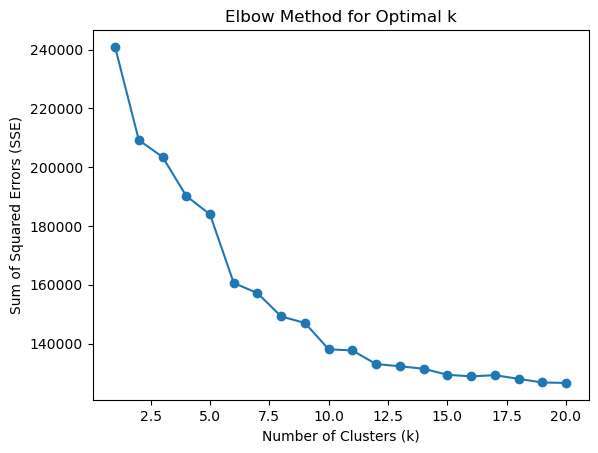

Elbow method for sampled data with PCA


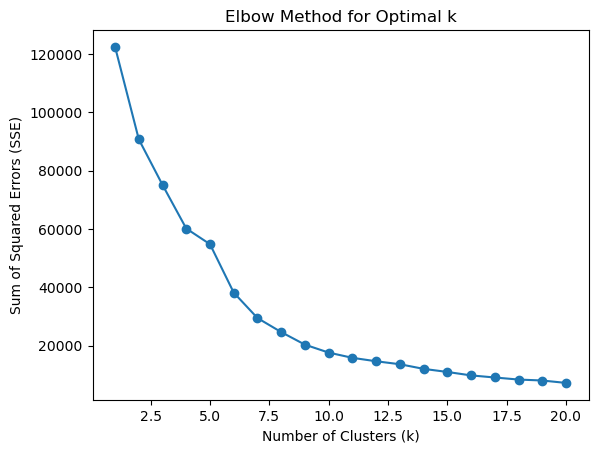

Elbow method for whole data with PCA


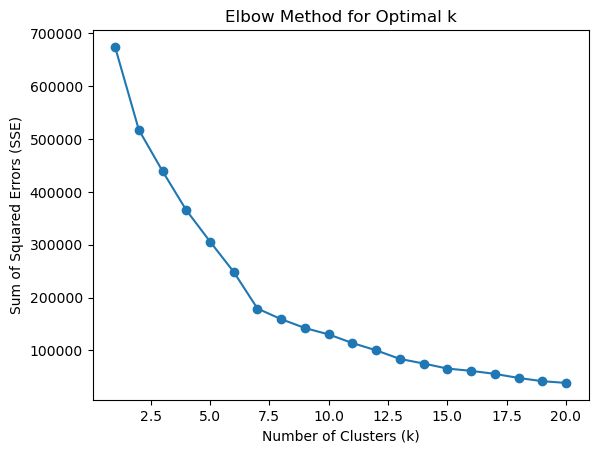

In [18]:
def elbow_method(data):
    # Elbow Method for Optimal k
    inertia_values = []

    for k in range(1, 21):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
        
    # Plot the graph of the elbow method
    plt.plot(range(1, 21), inertia_values, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal k')
    plt.show()

print("Elbow method for sampled data")
#elbow_method(x_encoded_sampled)
print("Elbow method for sampled data with PCA")
elbow_method(sampled_data_pca)
print("Elbow method for whole data with PCA")
elbow_method(X_pca)


### Silhouette Method

Silhouette method for sampled data
For k=3, Silhouette Score: 0.07894298926850636
For k=4, Silhouette Score: 0.03856115171732032
For k=5, Silhouette Score: 0.03418117527423422
For k=6, Silhouette Score: 0.04567021407607859
For k=7, Silhouette Score: 0.053050404061422494
For k=8, Silhouette Score: 0.04129208111914416
For k=9, Silhouette Score: 0.04839904520028193
For k=10, Silhouette Score: 0.0461625091515916

The best number of cluster (k) is: 3


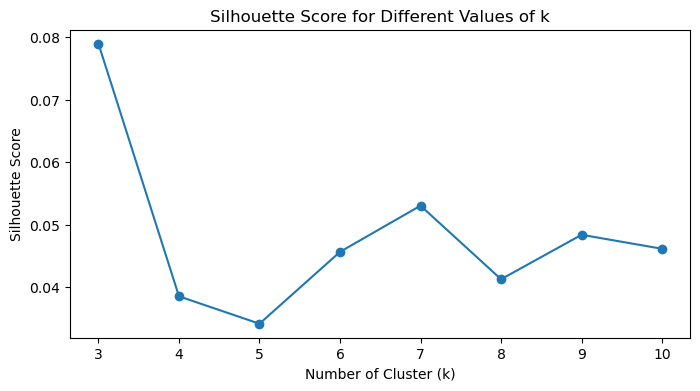

Silhouette method for sampled data with pca
For k=3, Silhouette Score: 0.8666735013552355
For k=4, Silhouette Score: 0.8716246016931972
For k=5, Silhouette Score: 0.28215253345807056
For k=6, Silhouette Score: 0.6820759219479798
For k=7, Silhouette Score: 0.6740791394406684
For k=8, Silhouette Score: 0.30472590589454795
For k=9, Silhouette Score: 0.3174126727241837
For k=10, Silhouette Score: 0.33350965368053537

The best number of cluster (k) is: 4


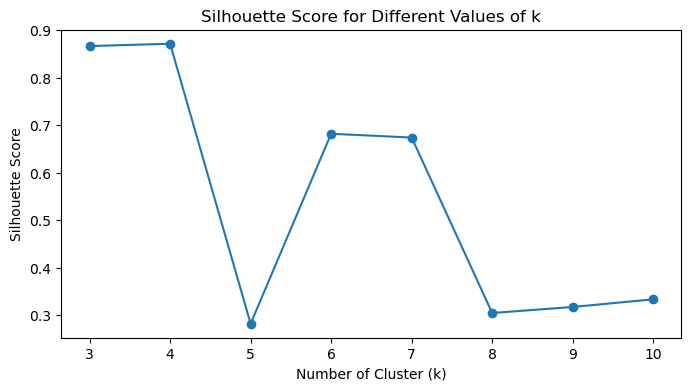

Silhouette method for whole data with pca
For k=3, Silhouette Score: 0.7563817964025575
For k=4, Silhouette Score: 0.7617322109404406
For k=5, Silhouette Score: 0.8051979528695131
For k=6, Silhouette Score: 0.7293040912741448
For k=7, Silhouette Score: 0.7295072777976411
For k=8, Silhouette Score: 0.36599072125011245
For k=9, Silhouette Score: 0.3692227268434711
For k=10, Silhouette Score: 0.42056124911090925

The best number of cluster (k) is: 5


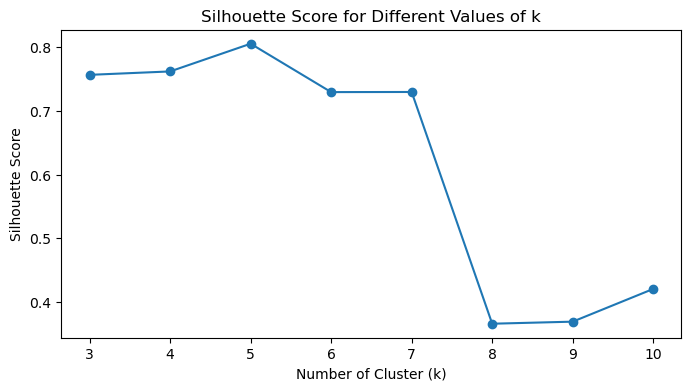

In [7]:
def silhouette_method(data):
    # Calculates the Silhouette Score for a range of values of k
    silhouette_scores = []
    possible_k_values = range(3,11) 

    for k in possible_k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For k={k}, Silhouette Score: {silhouette_avg}")

    # Find the value of k that maximizes the Silhouette Score
    best_k = possible_k_values[silhouette_scores.index(max(silhouette_scores))]

    # Print the best number of clusters
    print("\nThe best number of cluster (k) is:", best_k)

    # Plot the Silhouette Score graph
    plt.figure(figsize=(8, 4))
    plt.plot(possible_k_values, silhouette_scores, marker='o')
    plt.title('Silhouette Score for Different Values of k')
    plt.xlabel('Number of Cluster (k)')
    plt.ylabel('Silhouette Score')
    plt.show()
print("Silhouette method for sampled data")
#silhouette_method(x_encoded_sampled)
print("Silhouette method for sampled data with pca")
silhouette_method(sampled_data_pca)
print("Silhouette method for whole data with pca")
silhouette_method(X_pca)

### K-Means Application

In [43]:
def K_Means(data, k):
    num_clusters = k # Set the number of cluster
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Predict cluster and save into df
    labels = kmeans.fit_predict(data)
    df['Cluster'] = labels

    #Cluster size
    cluster_sizes = df['Cluster'].value_counts()
    print(cluster_sizes)

    # Stats cluster with initial data
    cluster_stats = df.groupby('Cluster').agg({
        'NUMBER OF PEDESTRIANS INJURED': ['mean', 'sum'],
        'NUMBER OF PEDESTRIANS KILLED': ['mean', 'sum'],
        'NUMBER OF MOTORIST INJURED': ['mean', 'sum'],
        'NUMBER OF MOTORIST KILLED': ['mean', 'sum'],
        'NUMBER OF CYCLIST INJURED': ['mean', 'sum'],
        'NUMBER OF CYCLIST KILLED': ['mean', 'sum'],
        'BOROUGH': lambda x: x.value_counts().idxmax(),
        'CONTRIBUTING FACTOR VEHICLE 1': lambda x: x.value_counts().idxmax(),
        'VEHICLE TYPE CODE 1': lambda x: x.value_counts().idxmax(),
        'ON STREET NAME': lambda x: x.value_counts().idxmax(),
        'ZIP CODE': lambda x: x.value_counts().idxmax(),
        'CRASH DATE': lambda x: x.value_counts().idxmax(),
        'CRASH TIME': lambda x: x.value_counts().idxmax(),
        'LATITUDE': lambda x: x.value_counts().idxmax(),
        'LONGITUDE': lambda x: x.value_counts().idxmax(),
        'CROSS STREET NAME' : lambda x: x.value_counts().idxmax()
    })
    #print(cluster_stats)
    #cluster_stats.to_csv("Originalkmeans.csv")

K_Means(X_pca, 5)

0    72822
4     1384
1      983
3      188
2       16
Name: Cluster, dtype: int64


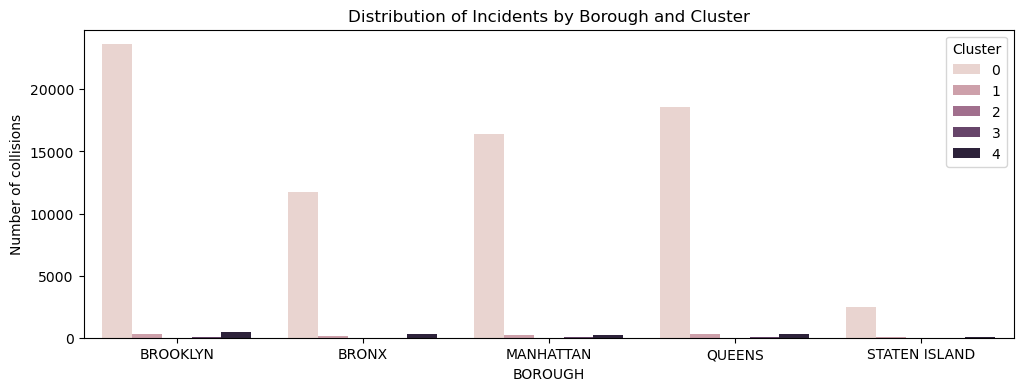

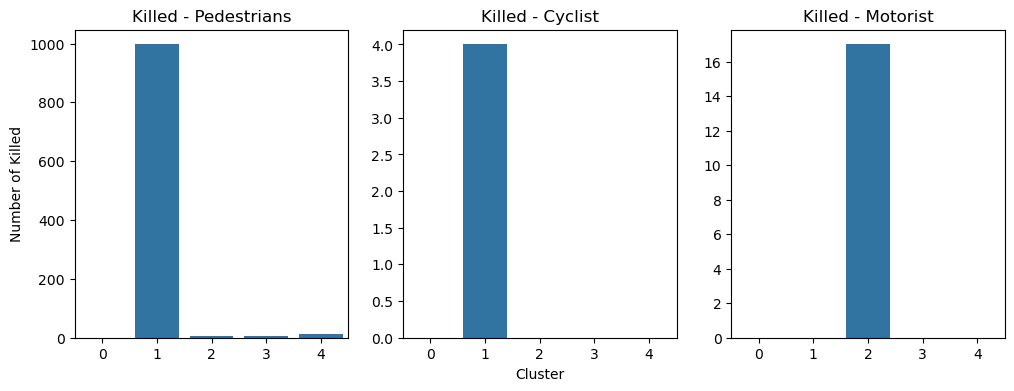

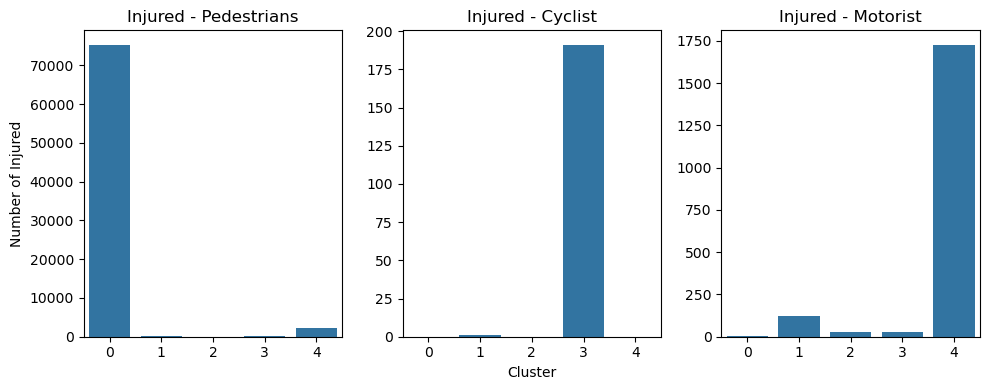

In [44]:
# View the distribution of accidents inside cluster by borough
plt.figure(figsize=(12, 4))
sns.countplot(x='BOROUGH', data=df, hue='Cluster')
plt.title('Distribution of Incidents by Borough and Cluster')
plt.xlabel('BOROUGH')
plt.ylabel('Number of collisions')
plt.show()

# View the distribution of accidents inside cluster by person killed
cluster_pedestrian = df.groupby('Cluster')['NUMBER OF PEDESTRIANS KILLED'].sum().reset_index()
cluster_cyclist = df.groupby('Cluster')['NUMBER OF CYCLIST KILLED'].sum().reset_index()
cluster_motorist = df.groupby('Cluster')['NUMBER OF MOTORIST KILLED'].sum().reset_index()

plt.figure(figsize=(12, 4))

# Pedestrians plot
plt.subplot(1, 3, 1)
sns.barplot(x='Cluster', y='NUMBER OF PEDESTRIANS KILLED', data=cluster_pedestrian)
plt.title('Killed - Pedestrians')
plt.xlabel('')
plt.ylabel('Number of Killed')

# Cyclist plot
plt.subplot(1, 3, 2)
sns.barplot(x='Cluster', y='NUMBER OF CYCLIST KILLED', data=cluster_cyclist)
plt.title('Killed - Cyclist')
plt.xlabel('Cluster')
plt.ylabel('')

# Motorist plot
plt.subplot(1, 3, 3)
sns.barplot(x='Cluster', y='NUMBER OF MOTORIST KILLED', data=cluster_motorist)
plt.title('Killed - Motorist')
plt.xlabel('')
plt.ylabel('')

# # View the distribution of accidents inside cluster by person injured
cluster_pedestrian_injured = df.groupby('Cluster')['NUMBER OF PEDESTRIANS INJURED'].sum().reset_index()
cluster_cyclist_injured = df.groupby('Cluster')['NUMBER OF CYCLIST INJURED'].sum().reset_index()
cluster_motorist_injured = df.groupby('Cluster')['NUMBER OF MOTORIST INJURED'].sum().reset_index()

plt.figure(figsize=(10, 4))

# Pedestrians injured
plt.subplot(1, 3, 1)
sns.barplot(x='Cluster', y='NUMBER OF PEDESTRIANS INJURED', data=cluster_pedestrian_injured)
plt.title('Injured - Pedestrians')
plt.xlabel('')
plt.ylabel('Number of Injured')

# Cyclist injured
plt.subplot(1, 3, 2)
sns.barplot(x='Cluster', y='NUMBER OF CYCLIST INJURED', data=cluster_cyclist_injured)
plt.title('Injured - Cyclist')
plt.xlabel('Cluster')
plt.ylabel('')

# Motorist injured
plt.subplot(1, 3, 3)
sns.barplot(x='Cluster', y='NUMBER OF MOTORIST INJURED', data=cluster_motorist_injured)
plt.title('Injured - Motorist')
plt.xlabel('')
plt.ylabel('')

# Show the histrograms
plt.tight_layout()
plt.show()

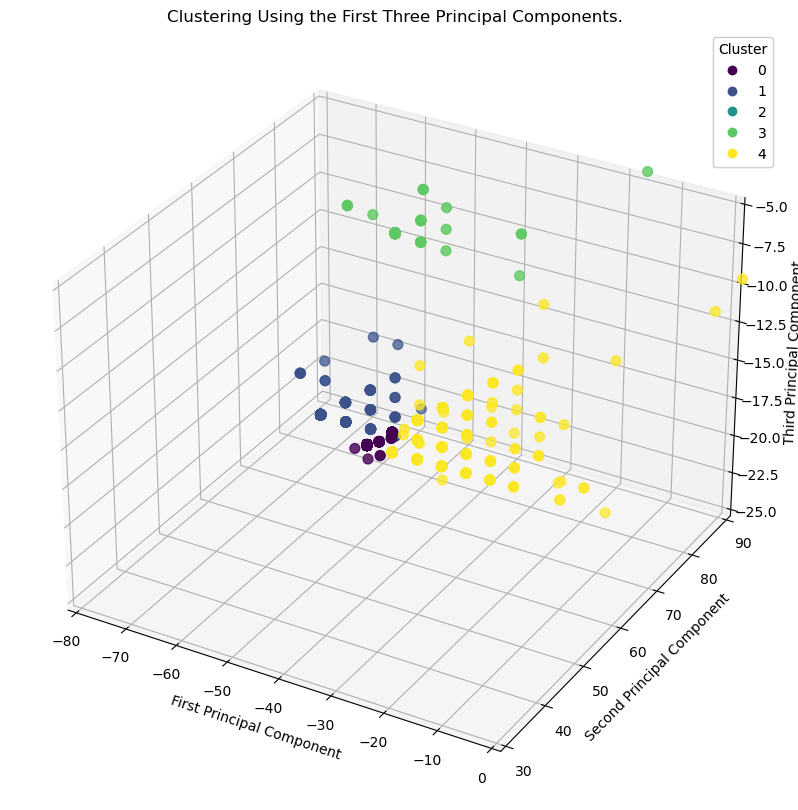

In [45]:
# Filter only on the first three components
X_3d = X_transformed[:, :3]

# Create a 3d area
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter graph
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=df['Cluster'], cmap='viridis', s=50)

# Add title and axis labels
ax.set_title('Clustering Using the First Three Principal Components.')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

ax.set_xlim(-80, 0)
ax.set_ylim(30, 90)
ax.set_zlim(-25, -5)

# Add legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster')
ax.add_artist(legend)

# Show the plot
plt.show()

In [46]:
# Create a DataFrame with the data
df_plotly = pd.DataFrame({'x': X_3d[:, 0], 'y': X_3d[:, 1], 'z': X_3d[:, 2], 'Cluster': df['Cluster']})

# Create the interactive 3D plot.
fig = px.scatter_3d(df_plotly, x='x', y='y', z='z', color='Cluster', opacity=0.8,
    color_continuous_scale='viridis', title='Clustering Using the First Three Principal Components.',
    labels={'x': 'First Principal Component', 'y': 'Second Principal Component', 'z': 'Third Principal Component'},size_max=50)

# Export the plot in HTML format.
fig.write_html("interactive_graph.html")

## K-Medoids

In [47]:
df = df_medoids

In [48]:
# Creates a subset of the original dataset containing only the data for years 2020, 2021, 2022
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')

df = df.dropna(subset=['CRASH DATE'])

# Select the years to create a subset of the original dataset
df_selected_years = df[df['CRASH DATE'].dt.year.isin([2020, 2021, 2022])]

percentage_90, X_transformed,_ = pca_application(df_selected_years)

X_pca_subset = X_transformed[:,:percentage_90]

Number of components needed for 50% variance: 3
Number of components needed for 60% variance: 4
Number of components needed for 80% variance: 6
Number of components needed for 90% variance: 8


In [49]:
def elbow_method_medoids(data):
    # Elbow Method for Optimal k
    inertia_values = []

    for k in range(1, 30):
        kmeans = KMedoids(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    # Plot the graph of the elbow method
    plt.plot(range(1, 30), inertia_values, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal k')
    plt.show()

def silhouette_method_medoids(data):
# Calculates the Silhouette Score for a range of values of k
    silhouette_scores = []
    possible_k_values = range(2,21) 

    for k in possible_k_values:
        kmeans = KMedoids(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
        #print(f"For k={k}, Silhouette Score: {silhouette_avg}")

    # Find the value of k that maximizes the Silhouette Score
    best_k = possible_k_values[silhouette_scores.index(max(silhouette_scores))]

    # Print the best number of clusters
    print("\nThe best number of cluster (k) is:", best_k, "with a score of",silhouette_scores[best_k - 1])

    # Plot the Silhouette Score graph
    plt.figure(figsize=(8, 4))
    plt.plot(possible_k_values, silhouette_scores, marker='o')
    plt.title('Silhouette Score for Different Values of k')
    plt.xlabel('Number of Cluster (k)')
    plt.ylabel('Silhouette Score')
    plt.show()
    return best_k

Elbow method for selected data


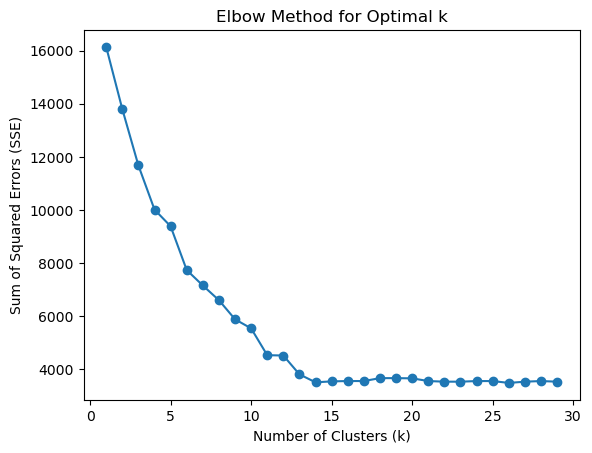

Silhouette method for selected data

The best number of cluster (k) is: 15 with a score of 0.6387415555688472


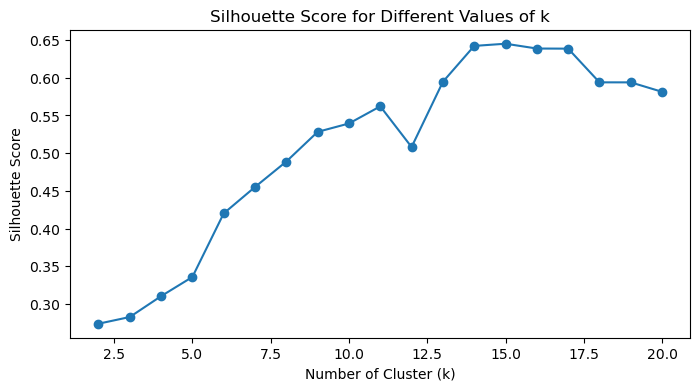

In [50]:
print("Elbow method for selected data")
elbow_method_medoids(X_pca_subset)

print("Silhouette method for selected data")
k = silhouette_method_medoids(X_pca_subset)

# Function that computes K-Medoids
def kmedoids(data, X, k):
    num_clusters = k 
    kmedoids = KMedoids(n_clusters=num_clusters, random_state=42)

    # Train the model
    kmedoids.fit(X)

    # Assign clusters to observations
    clusters = kmedoids.labels_
    data['Cluster'] = clusters

    # Clusters Dimensions
    #unique_clusters, cluster_sizes = np.unique(clusters, return_counts=True)
    #for cluster, size in zip(unique_clusters, cluster_sizes):
    #    print(f'Cluster {cluster}: {size} osservazioni')
kmedoids(df_selected_years,X_pca_subset, k)


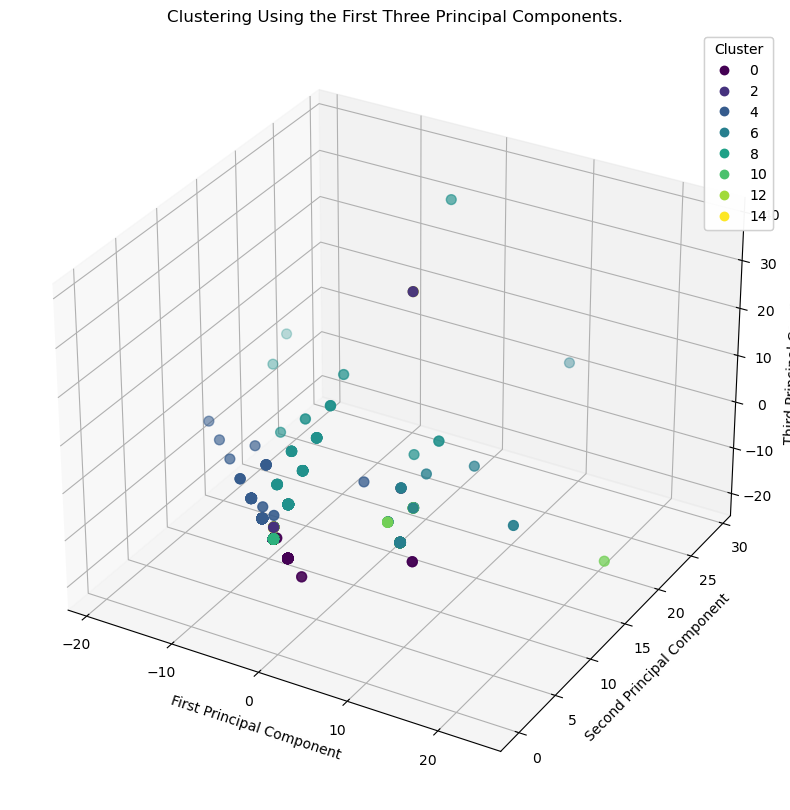

In [51]:
# Filter only on the first three components
X_3d = X_transformed[:, :3]

# Create a 3d area
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create the scatter graph
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=df_selected_years['Cluster'], cmap='viridis', s=50)

# Add title and axis labels
ax.set_title('Clustering Using the First Three Principal Components.')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

#ax.set_xlim(-80, 0)
#ax.set_ylim(30, 90)
#ax.set_zlim(-25, -5)

# Add legend
legend = ax.legend(*scatter.legend_elements(), title='Cluster')
ax.add_artist(legend)

# Show the plot
plt.show()

In [52]:
# Create a DataFrame with the data
df_plotly = pd.DataFrame({'x': X_3d[:, 0], 'y': X_3d[:, 1], 'z': X_3d[:, 2], 'Cluster': df_selected_years['Cluster']})

# Create the interactive 3D plot.
fig = px.scatter_3d(df_plotly, x='x', y='y', z='z', color='Cluster', opacity=0.8,
    color_continuous_scale='viridis', title='Clustering Using the First Three Principal Components.',
    labels={'x': 'First Principal Component', 'y': 'Second Principal Component', 'z': 'Third Principal Component'},size_max=50)

# Export the plot in HTML format.
fig.write_html("interactive_graph_medoids.html")

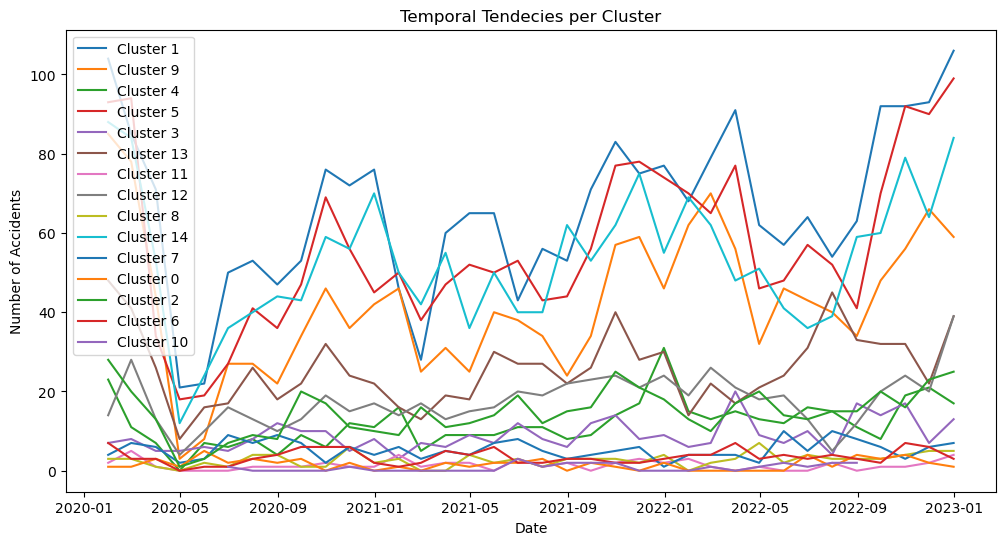

In [53]:
# Temporal plot for each cluster
plt.figure(figsize=(12, 6))

# For every cluster group by month
for cluster_id in df_selected_years['Cluster'].unique():
    cluster_data = df_selected_years[df_selected_years['Cluster'] == cluster_id]
    cluster_data = cluster_data.set_index('CRASH DATE').resample('M').size()
    plt.plot(cluster_data.index, cluster_data, label=f'Cluster {cluster_id}')

plt.title('Temporal Tendecies per Cluster')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()


In [54]:
# Based on the cluster obtained we specify the severity of each cluster based on the number of accidents that has grouped.
severity_classification = {}

for cluster_id in df_selected_years['Cluster'].unique():
    cluster_data = df_selected_years[df_selected_years['Cluster'] == cluster_id]
    cluster_data_resampled = cluster_data.set_index('CRASH DATE').resample('M').size() 
    total_incidents = cluster_data_resampled.sum()

    # If a cluster reaches certain thresholds it gets classified differently
    months_above_50 = len(cluster_data_resampled[cluster_data_resampled > 50])
    months_between_20_and_50 = len(
        cluster_data_resampled[(cluster_data_resampled >= 20) & (cluster_data_resampled <= 50)]
    )

    # Then the severity is decided for each cluster
    if months_above_50 >= 4: 
        severity = 'High'
    elif months_between_20_and_50 >= 3: 
        severity = 'Medium'
    else: 
        severity = 'Low'

    severity_classification[cluster_id] = severity

# Uncomment this to see how the severity has been assigned to each cluster
#for cluster_id, severity in severity_classification.items():
#    print(f'Cluster {cluster_id}: {severity}')

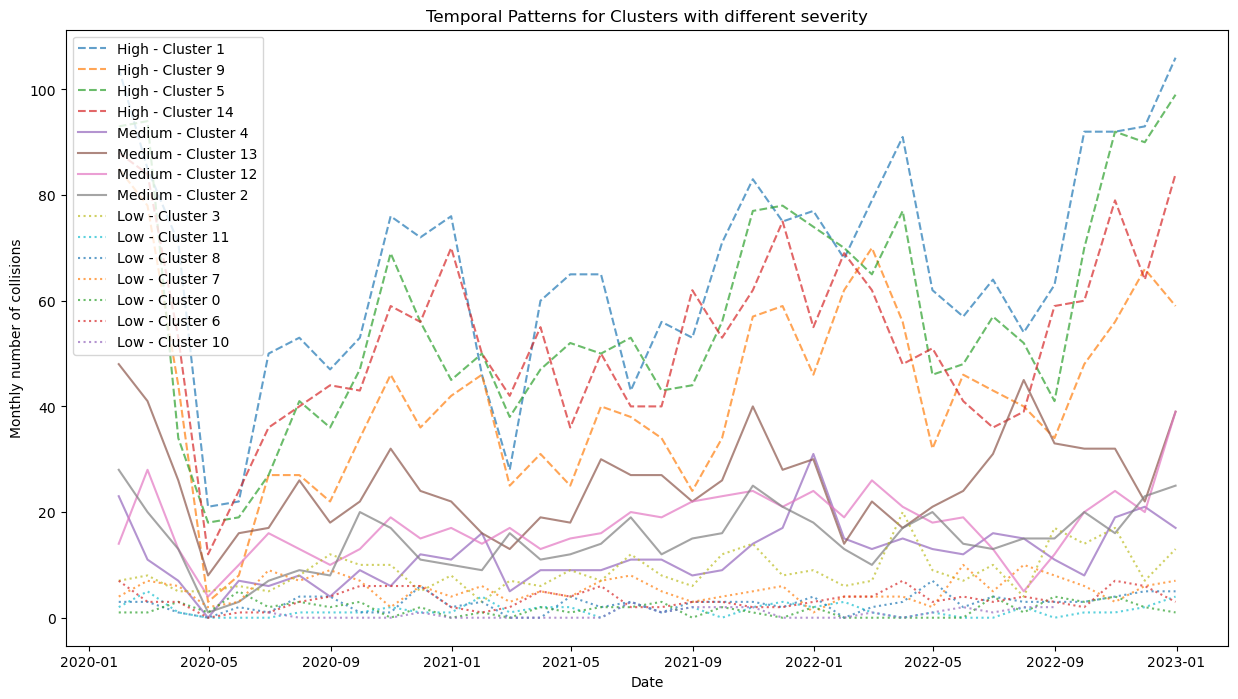

In [55]:
# Create the dictionaries
severe_clusters = {}
medium_clusters = {}
light_clusters = {}

for cluster_id, severity in severity_classification.items():
    cluster_data = df_selected_years[df_selected_years['Cluster'] == cluster_id]
    cluster_data_resampled = cluster_data.set_index('CRASH DATE').resample('M').size()

    # Add the clusters to thei respective dictionaries
    if severity == 'High':
        severe_clusters[cluster_id] = cluster_data_resampled
    elif severity == 'Medium':
        medium_clusters[cluster_id] = cluster_data_resampled
    else:
        light_clusters[cluster_id] = cluster_data_resampled

# Plot the final graph
plt.figure(figsize=(15, 8))

for cluster_id, data in severe_clusters.items():
    plt.plot(data.index, data, label=f'High - Cluster {cluster_id}', linestyle='--', alpha=0.7)

for cluster_id, data in medium_clusters.items():
    plt.plot(data.index, data, label=f'Medium - Cluster {cluster_id}', linestyle='-', alpha=0.7)

for cluster_id, data in light_clusters.items():
    plt.plot(data.index, data, label=f'Low - Cluster {cluster_id}', linestyle=':', alpha=0.7)

plt.title('Temporal Patterns for Clusters with different severity')
plt.xlabel('Date')
plt.ylabel('Monthly number of collisions')
plt.legend()
plt.show()

In [56]:
# Function used to compute statistics on each cluster
def cluster_analysis(selected_clusters):
    # Create an empty list to store rows for the table
    table_rows = []

    # Filter the clusters
    df_selected_clusters = df_selected_years[df_selected_years['Cluster'].isin(selected_clusters)]

    # Analyze each cluster
    for cluster_id in selected_clusters:
        cluster_data = df_selected_clusters[df_selected_clusters['Cluster'] == cluster_id]

        # Main Borough
        main_borough = cluster_data['BOROUGH'].mode().iloc[0]

        # Main On Street Name
        main_on_street_name = cluster_data['ON STREET NAME'].mode().iloc[0] if not cluster_data['ON STREET NAME'].empty else 'N/A'

        # Main Motivation
        main_contributing_factor = cluster_data['CONTRIBUTING FACTOR VEHICLE 1'].mode().iloc[0]

        # Main Vehicle involved
        main_vehicle_type = cluster_data['VEHICLE TYPE CODE 1'].mode().iloc[0]

        # Main Time
        main_crash_time = cluster_data['CRASH TIME'].mode().iloc[0] if not cluster_data['CRASH TIME'].empty else 'N/A'

        # Append row to the table
        table_rows.append([cluster_id, main_borough, main_contributing_factor, main_on_street_name, main_vehicle_type, main_crash_time])

    # Define the columns for the table
    headers = ["Cluster ID", "Main Borough", "Main Motivation", "Main On Street Name", "Main Vehicle Involved", "Main Time"]

    # Print the table
    print(tabulate(table_rows, headers=headers, tablefmt="grid"))

# Print tables for each severity
print("High Severity")
cluster_analysis([1, 9, 5, 14])
print("\nMedium Severity")
cluster_analysis([2, 12, 13, 4])
print("\nLow Severity")
cluster_analysis([0, 3, 11, 8, 7, 6, 10])

High Severity
+--------------+----------------+-------------------------------+-----------------------+-------------------------------------+-------------+
|   Cluster ID | Main Borough   | Main Motivation               | Main On Street Name   | Main Vehicle Involved               | Main Time   |
+==============+================+===============================+=======================+=====================================+=============+
|            1 | BROOKLYN       | driver inattention            | 3 AVENUE              | Sedan                               | 0:00        |
+--------------+----------------+-------------------------------+-----------------------+-------------------------------------+-------------+
|            9 | QUEENS         | failure to yield right-of-way | JAMAICA AVENUE        | Station Wagon/Sport Utility Vehicle | 18:00       |
+--------------+----------------+-------------------------------+-----------------------+-------------------------------------+-------